<a href="https://colab.research.google.com/github/skywalker0803r/crypto/blob/main/%E5%9B%9E%E6%B8%AC%E5%88%86%E6%9E%90%E8%99%9B%E6%93%AC%E8%B2%A8%E5%B9%A3%E5%90%8C%E6%99%82%E7%AB%8B%E5%8D%B3%E7%B5%A6%E5%87%BA%E8%A8%8A%E8%99%9F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
!pip install finlab_crypto > log.txt

# 設定

In [23]:
pairs = ['BNBUSDT'] #交易對
freq = '15m' # 資料頻率

# 跑回測取得n1n2

All caught up..!


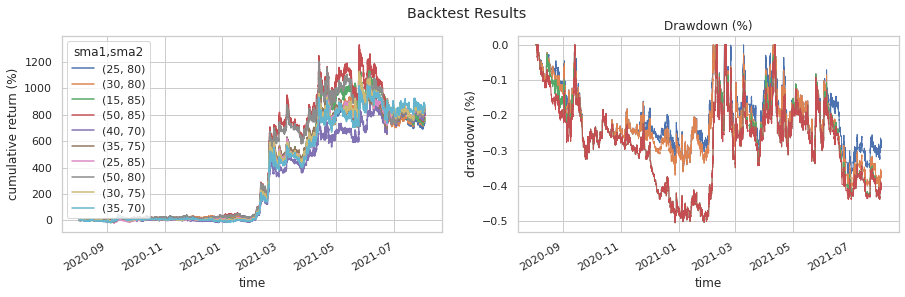

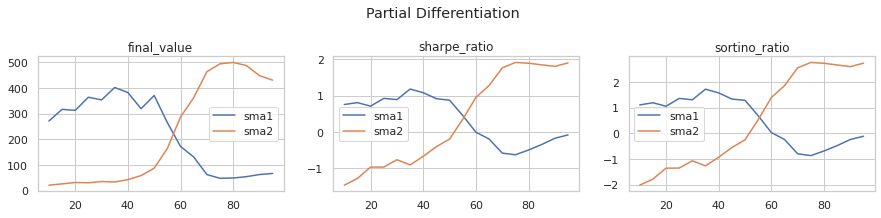

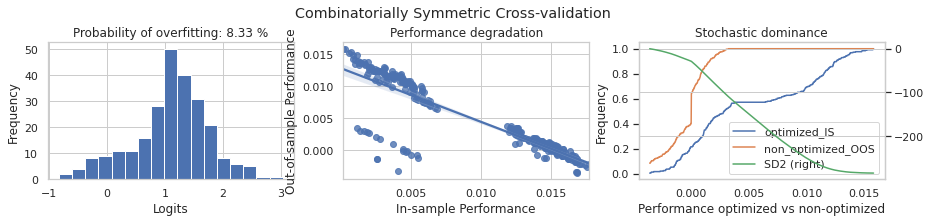

Output()

In [24]:
import numpy as np
import finlab_crypto
from finlab_crypto import Strategy


n1n2 = {}
for i in pairs:
  n1n2[i] = []

def Optimization(pair,freq):
  # 歷史價格數據
  ohlcv = finlab_crypto.crawler.get_all_binance(pair,freq)
  ohlcv = ohlcv.loc['2020-08-03':,:]

  #定義策略
  @Strategy(sma1=20, sma2=60)
  def sma_strategy(ohlcv):
    # 定義均線策略進出場條件
    close = ohlcv.close
    sma1 = close.rolling(sma_strategy.sma1).mean()
    sma2 = close.rolling(sma_strategy.sma2).mean()
    entries = (sma1 > sma2) & (sma1.shift() < sma2.shift())
    exits = (sma1 < sma2) & (sma1.shift() > sma2.shift())
    figures = {'overlaps': {'sma1': sma1,'sma1': sma2}}
    return entries, exits, figures

  # 策略超參數
  variables = {
      'sma1': np.arange(10, 100, 5), 
      'sma2': np.arange(10, 100, 5),
      }

  #回測及優化
  portfolio = sma_strategy.backtest(ohlcv, variables=variables, freq=freq ,plot=True)
  temp = portfolio.total_profit()[portfolio.total_profit()==portfolio.total_profit().max()].to_frame().reset_index()
  n1n2[pair] = [temp['sma1'].values[0],temp['sma2'].values[0]]

for pair in pairs:
  portfolio = Optimization(pair,freq)

In [25]:
n1n2

{'BNBUSDT': [35, 70]}

In [26]:
config = {}
for i in pairs:
  config[i] = {'n1':n1n2[i][0],'n2':n1n2[i][1]}
config

{'BNBUSDT': {'n1': 35, 'n2': 70}}

# 使用n1n2產生訊號

All caught up..!


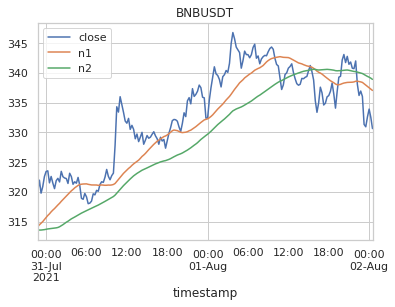

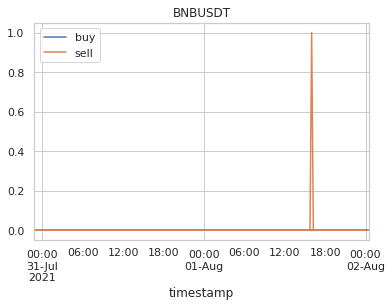

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

dfs = {}
lookback = 200 # 往回看看多長時間
for pair in config.keys():
  ohlcv = finlab_crypto.crawler.get_all_binance(pair,freq)
  ohlcv = ohlcv.loc['2020-08-03':,:]
  table = pd.DataFrame()
  table['close'] = ohlcv.close
  table['n1'] = ohlcv.close.rolling(config[pair]['n1']).mean()
  table['n2'] = ohlcv.close.rolling(config[pair]['n2']).mean()
  table.tail(lookback).plot(title=pair)
  plt.show()
  table['buy'] = ((table['n1'] > table['n2'])&(table['n1'].shift() < table['n2'].shift())).astype(int)
  table['sell'] = ((table['n1'] < table['n2'])&(table['n1'].shift() > table['n2'].shift())).astype(int)
  table[['buy','sell']].tail(lookback).plot(title=pair)
  dfs[pair] = table
  plt.show()

# 查看訊號dataframe

In [28]:
import numpy as np
pd.options.display.max_rows = 999
for pair in config.keys():
  dfs[pair] = dfs[pair].replace(0,np.nan)
  display((dfs[pair].dropna(subset=['buy','sell'],how='all').tail(5)).style.background_gradient(subset=['buy','sell']))

,close,n1,n2,buy,sell
timestamp,,,,,
2021-07-29 22:15:00+00:00,313.950000,313.970286,313.978714,nan,1.000000
2021-07-29 23:00:00+00:00,316.530000,314.070000,314.035571,1.000000,nan
2021-07-30 11:45:00+00:00,309.240000,315.973143,316.279571,nan,1.000000
2021-07-30 22:15:00+00:00,319.890000,313.603143,313.580286,1.000000,nan
2021-08-01 16:00:00+00:00,335.310000,340.541429,340.561429,nan,1.000000
